<a href="https://colab.research.google.com/github/aditya33agrawal/NLP-Tweet-Emotion/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Installing Hugging Face's nlp package
2. Importing libraries

In [44]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


1.   Importing the Tweet Emotion dataset.
2.   Creating train, validation and test sets.
3.   Extracting tweets and labels from the examples.

In [46]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [48]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [49]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [50]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets,  labels

In [51]:
tweets , labels = get_tweet(train) 

In [52]:
tweets[0] , labels[0]

('i didnt feel humiliated', 0)

Tokenizing the tweets (words to numbers)

In [53]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [54]:
tokenizer = Tokenizer(num_words = 10000 , oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [55]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [56]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

1.   Checking length of the tweets.
2.   Creating padded sequences.

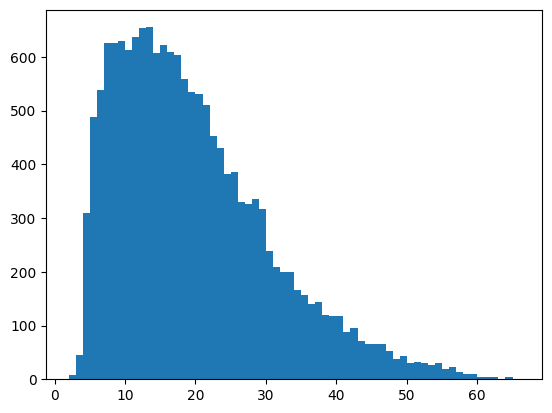

In [57]:
length = [len(t.split(' ')) for t in tweets]
plt.hist(length, bins = len(set(length)))
plt.show()

In [58]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [59]:
maxlength = 50

In [60]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post' , padding = 'post' , maxlen = maxlength)
  return padded

In [61]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [62]:
padded_train_seq[211]

array([   2,   47, 7503,   90,   22,    7, 7504,  223,    5,  101,   49,
         31,   44,   12,    6, 7505, 1127,   19, 7506, 5333,    5,   23,
       1127,   67,    5,  354,   81,   16,    6, 5334,    3,    6,  706,
       7507,   10,    6, 7508, 5335,  928,  615,    6, 3091, 7509,    4,
       3088, 2307,  375,   12,  169,    6], dtype=int32)



1.   Creating classes to index and index to classes dictionaries.
2.   Converting text labels to numeric labels.


In [63]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


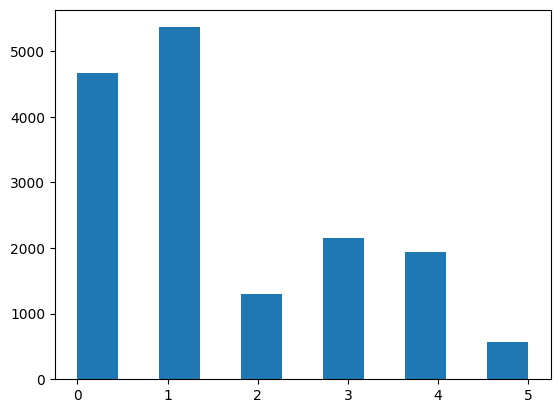

In [64]:
plt.hist(labels, bins = 11)
plt.show()

In [65]:
index_to_class = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
}

In [66]:
label_num = index_to_class[4]
print(label_num)

fear


In [67]:
print(labels[1])

0




1.  Creating the model.
2.   Compiling the model.



In [68]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = maxlength),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________




1.   Preparing a validation set.
2.   Training the model.



In [70]:
val_tweets , val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)

In [71]:
val_tweets[0] , val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [72]:
import numpy as np
train_labels = np.array(labels)
val_labels = np.array(val_labels)

print(type(train_labels))
print(type(val_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [73]:
from keras.callbacks import EarlyStopping
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = ( val_seq , val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping( monitor = 'val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 32s 52ms/step - loss: 1.2835 - accuracy: 0.5046 - val_loss: 0.8735 - val_accuracy: 0.6520
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.5278 - accuracy: 0.8181 - val_loss: 0.4828 - val_accuracy: 0.8420
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2918 - accuracy: 0.9079 - val_loss: 0.4172 - val_accuracy: 0.8675
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1988 - accuracy: 0.9379 - val_loss: 0.3521 - val_accuracy: 0.8795
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1473 - accuracy: 0.9530 - val_loss: 0.3755 - val_accuracy: 0.8785
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1108 - accuracy: 0.9649 - val_loss: 0.3433 - val_accuracy: 0.8925
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.0878 - accuracy: 0.9716 - val_loss: 0.3942 - val_accuracy: 0.891



1.   Visualizing training history.
2.   Prepraring a test set.
3.   A look at individual predictions on the test set.
4.   A look at all predictions on the test set.



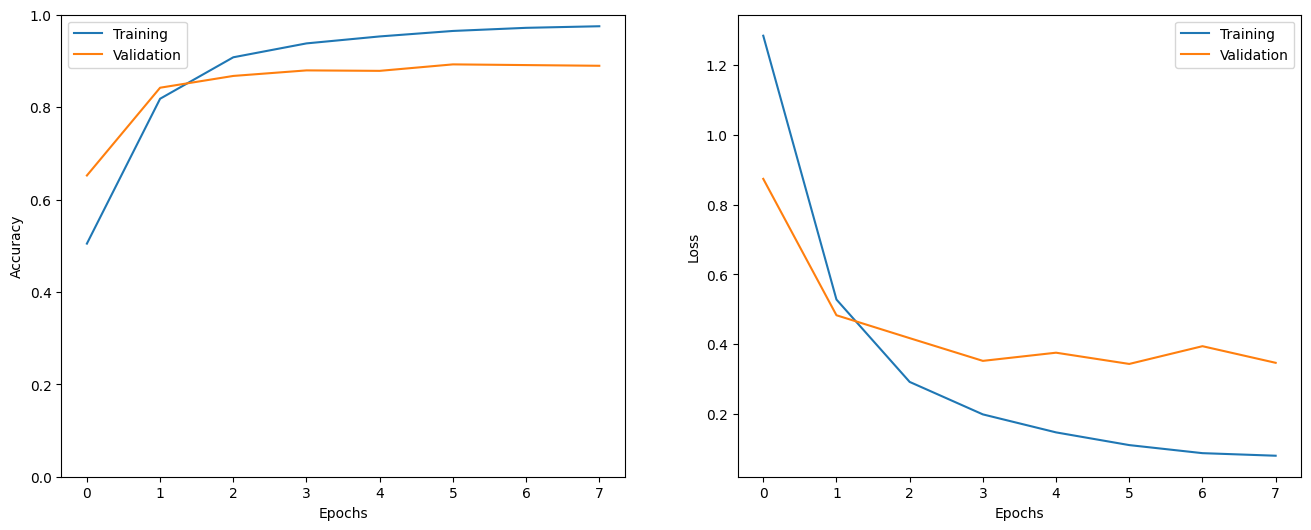

In [101]:
show_history(h)

In [75]:
test_tweets , test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)

In [77]:
test_labels = np.array(test_labels)

In [78]:
_ = model.evaluate( test_seq , test_labels )

63/63 [==============================] - 0s 7ms/step - loss: 0.3891 - accuracy: 0.8770


In [88]:
i = random.randint( 0 , len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i said before do feel free to contact me this is something i am interested in finding out more about
Emotion: joy
1/1 [==============================] - 0s 22ms/step
Predicted Emotion: joy


In [99]:
# preds = model.predict_classes(test_seq)
preds = np.argmax(model.predict(test_seq),axis=1)

63/63 [==============================] - 0s 7ms/step


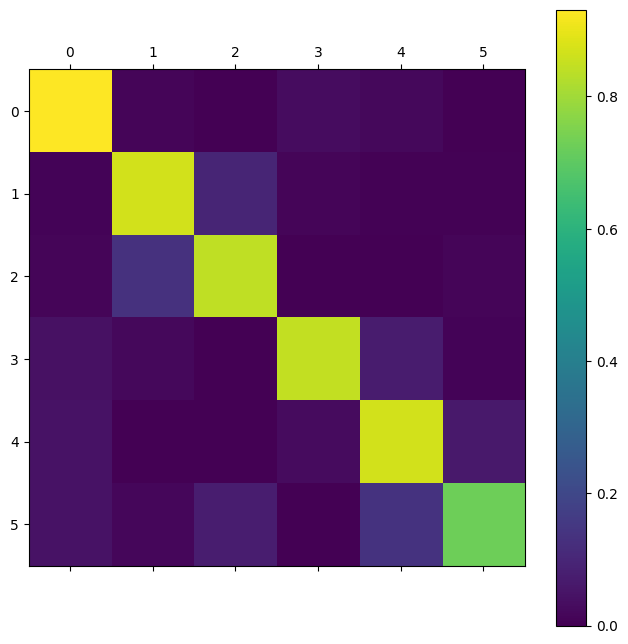

In [100]:
show_confusion_matrix(test_labels, preds, list(classes))